In [16]:
from itertools import product

import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os
from sklearn.cluster import KMeans

In [17]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    """
    Rotates a 2D tuple (point) by a given angle in degrees.

    Args:
        point: A tuple (x, y).
        angle_degrees: Angle to rotate the point, in degrees.

    Returns:
        A tuple (x', y') representing the rotated point.
    """
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def multiply_tuple(point, scale):
    return tuple(element * scale for element in point)

def add_tuple(x, y):
    return (x[0] + y[0], x[1] + y[1])

In [18]:
def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude_squared(v):
        return v[0]**2 + v[1]**2
    
    # Unpack rectangle vertices
    A, B, C, D = rect
    
    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)
    
    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)
    
    return within_AB and within_AD

In [19]:
class Product:
  def __init__(self, position, width, height, cornerpoints):
    self.position = position
    self.width = width
    self.height = height
    self.cornerpoints = cornerpoints

Pos:(184, 214), Width:350, Height:498
Pos:(550, 218), Width:333, Height:488
Pos:(1261, 232), Width:311, Height:440
Pos:(921, 218), Width:332, Height:486


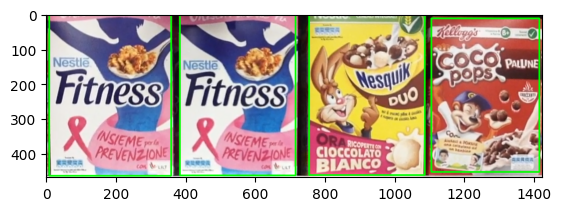

In [30]:
def find_image(scene_path, model_paths, draw_on_color=True, MIN_MATCH_COUNT=80, GRID_RESOLUTION=25, MIN_VOTES=25):
    target_resolution = (150,210) #(250, 350) # aspect ratio: 4.2/3 or 1.4/1
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)
    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    result = []

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        #print(f"Looking for {model["name"]}...")

        # Apply model preprocessing
        model_gray = model["img"]
        model_gray = cv.resize(model_gray, target_resolution, interpolation=cv.INTER_AREA)

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        #result = scene_to_draw_on

        src_kp = [kp_model[m.queryIdx] for m in good]
        dst_kp = [kp_scene[m.trainIdx] for m in good]

    #--------------------------------------------------------------------------------------
    # Selection via Homography
        """MIN_INLIERS = 10

        if len(good) >= MIN_MATCH_COUNT:
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
            matches_mask = mask.ravel().tolist()

            if M is not None and sum(matches_mask) > MIN_INLIERS:
                # Accept only if enough inliers are found
                print("Object correctly validated using homography:", sum(matches_mask))
            else:
                print("False positive detected or homography failed:", sum(matches_mask))
        """

    #--------------------------------------------------------------------------------------
    # Selection via Weighted sum of Distance
        """DISTANCE_THRESHOLD = 30
        # Weigh matches based on distances
        weighted_matches = [m.distance for m in good]
        weight_sum = sum(weighted_matches)
        print("Weighted distances:", weight_sum)

        if weight_sum < DISTANCE_THRESHOLD:
            print("Image validated based on weighted distances")
        else:
            print("False positive detected based on weights")"""

    #--------------------------------------------------------------------------------------
    # Selection via Grid Feature Threshold
        """THRESHOLD_GRIDS = 9

        # Define the dimensions of the target image
        h, w = model_gray.shape
        grid_size_x = 2  # Divide image into a grid (e.g., 5x5)
        grid_size_y = 5
        grid_matches = [[0] * grid_size_x for _ in range(grid_size_y)]

        for match in good:
            x, y = kp_model[match.queryIdx].pt  # Get match coordinates
            grid_x = int(x / (w / grid_size_x))
            grid_y = int(y / (h / grid_size_y))
            grid_matches[grid_y][grid_x] += 1

        # Count non-empty grid cells
        matched_grids = sum(1 for row in grid_matches for cell in row if cell > 0)

        if matched_grids >= THRESHOLD_GRIDS:
            print("Valid match (well-distributed keypoints):", matched_grids)
        else:
            print("False positive (poorly distributed keypoints):", matched_grids)
            continue"""


        if len(good)>=MIN_MATCH_COUNT:
            #print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            tmp = scene_to_draw_on.copy()

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                #delta_phi = d.angle/s.angle
                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)


            x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
            y_cell = x_cell

            y_cells_n = int(scene_gray.shape[1]//y_cell + 1)

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            # assign features matches and barycenters to grids
            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)

            # select vote winners in grid
            barygrid_means = []
            winners = []
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))

            i = 0

            ignored_area = []

            for winner, barygrid_mean in zip(winners, barygrid_means):

                # check if Winner is in area with already found winner
                winner_found = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        winner_found = True
                        break
                if winner_found:
                    continue


                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                matchesMask = mask.ravel().tolist()
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)
                #print(dst[0][0][0])
                """height_1 = dst[1][0][1] - dst[0][0][1]
                height_2 = dst[2][0][1] - dst[3][0][1]
                height = int((height_1 + height_2)/2)
                #print("Height:",height)

                width_1 = dst[3][0][0] - dst[0][0][0]
                width_2 = dst[2][0][0] - dst[1][0][0]
                width = int((width_1 + width_2)/2)
                #print("Width:",width)

                x_1 = dst[3][0][0] - width_1/2
                x_2 = dst[2][0][0] - width_2/2
                x = int((x_1 + x_2)/2)
                #print("X:",x)

                y_1 = dst[1][0][1] - height_1/2
                y_2 = dst[2][0][1] - height_2/2
                y = int((y_1 + y_2)/2)
                #print("Y:",y)

                product = Product((x,y), width, height, dst)

                result.append(product)"""

                # Compute height as the average of two height measurements
                height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

                # Compute width as the average of two width measurements
                width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

                # Compute center X coordinate
                x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                         (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

                # Compute center Y coordinate
                y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                         (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

                # Create product object and append to result list
                result.append(Product((x, y), width, height, dst))

                #add square and add text
                """means = np.mean(dst, axis=0)
                x, y = [a for a in means[0]]
                x = x * 0.8 #adjust for text

                result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

                boldness = 3
                size = 3
                cv.putText(scene_to_draw_on, f"{model["name"]}", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                cv.putText(scene_to_draw_on, f"({i})", (int(x),int(y)+60), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                i = i + 1
                """
                ignored_area.append([o[0] for o in np.int32(dst)])

        #else:
        #    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        #    matchesMask = None

    #print("------------------------------------------")
    #print("Results:")
    return result


#define models to be searched in image
scene = "m1.png"
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
result = find_image(scene_path=get_path_scene(scene),
                    model_paths=models,
                    draw_on_color=True)

scene_gray = cv.imread(get_path_scene(scene))
for product in result:
    print(f"Pos:{product.position}, Width:{product.width}, Height:{product.height}")
    cv.rectangle(scene_gray,
                 (product.position[0] - int(product.width/2), product.position[1] - int(product.height/2)),
                 (product.position[0] + int(product.width/2), product.position[1] + int(product.height/2)),
                 (0,255,0),3)

plt.imshow(cv.cvtColor(scene_gray, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Enough matches are found - 205/80
4.1433806
448.16785
Looking for 1.jpg...
Not enough matches are found - 79/80
Looking for 11.jpg...
Not enough matches are found - 76/80
Looking for 19.jpg...
Not enough matches are found - 1/80
Looking for 24.jpg...
Not enough matches are found - 2/80
Looking for 25.jpg...
Not enough matches are found - 9/80
Looking for 26.jpg...
Not enough matches are found - 62/80


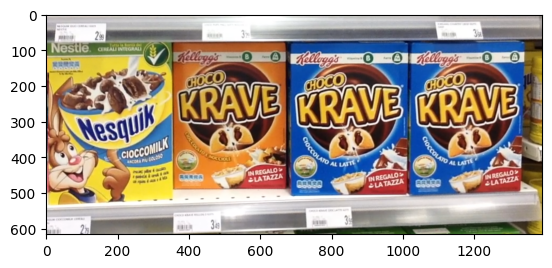

In [8]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m2.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Not enough matches are found - 69/80
Looking for 1.jpg...
Not enough matches are found - 14/80
Looking for 11.jpg...
Not enough matches are found - 3/80
Looking for 19.jpg...
Enough matches are found - 189/80
1088.5767
382.00598
Looking for 24.jpg...
Not enough matches are found - 2/80
Looking for 25.jpg...
Enough matches are found - 115/80
393.8285
457.9732
735.73425
445.0092
Looking for 26.jpg...
Enough matches are found - 271/80
11.291715
505.1062


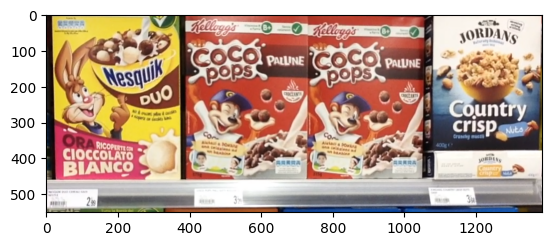

In [9]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m3.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Not enough matches are found - 46/80
Looking for 1.jpg...
Not enough matches are found - 12/80
Looking for 11.jpg...
Not enough matches are found - 4/80
Looking for 19.jpg...
Not enough matches are found - 1/80
Looking for 24.jpg...
Enough matches are found - 124/80
-24.040466
505.11395
360.6071
498.5315
Looking for 25.jpg...
Enough matches are found - 107/80
1115.5934
453.7483
Looking for 26.jpg...
Enough matches are found - 214/80
749.73663
492.63556


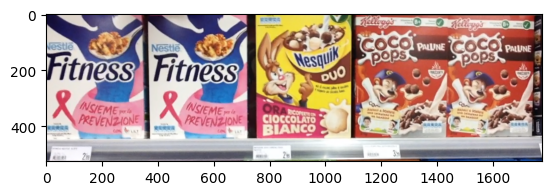

In [10]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m4.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Not enough matches are found - 1/80
Looking for 1.jpg...
Not enough matches are found - 68/80
Looking for 11.jpg...
Not enough matches are found - 64/80
Looking for 19.jpg...
Enough matches are found - 165/80
764.4069
383.2256
Looking for 24.jpg...
Not enough matches are found - 4/80
Looking for 25.jpg...
Enough matches are found - 91/80
74.67207
573.43054
410.578
443.76288
Looking for 26.jpg...
Not enough matches are found - 4/80


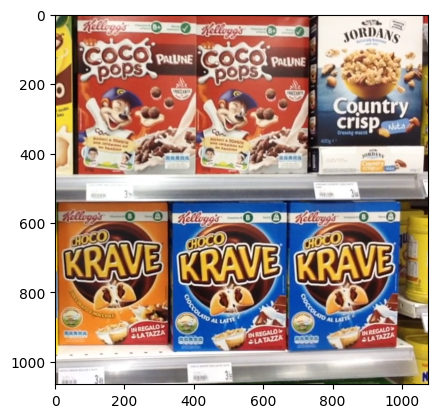

In [11]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m5.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()